[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fisamz/Repositorio_MCDAA/blob/main/Tarea4/Tarea4.ipynb)

# Tarea 4 — Selección de características  
**Alumno:** Fisam Zavala  
**Dataset:** Mental Health and Lifestyle Habits (2019–2024)  
**Fuente:** [Kaggle – Atharva Soundankar](https://www.kaggle.com/datasets/atharvasoundankar/mental-health-and-lifestyle-habits-2019-2024)


## Modelos de selección de características (filtro y wrapper)

Se aplican **tres enfoques de selección de características** sobre el conjunto de datos, con el objetivo de identificar las variables más relevantes para explicar el `Happiness Score`.  
Cada método se elige considerando sus **supuestos estadísticos** y su **naturaleza (univariada o multivariada)**.

---

### SelectKBest – F (f_regression)
- **Tipo:** Método de filtro paramétrico.  
- **Qué evalúa:** la fuerza de la **relación lineal individual** entre cada variable explicativa y la variable dependiente mediante el estadístico F de ANOVA.  
- **Supuestos principales:**  
  - Relación aproximadamente lineal entre `X` y `y`.  
  - Residuos con distribución aproximadamente normal.  
  - Independencia entre observaciones.  
- **Interpretación:** valores F más altos y p-valores pequeños indican mayor relevancia.  
  Este método no detecta relaciones no lineales ni interacciones entre variables.

### SelectKBest – Mutual Information (MI)
- **Tipo:** Método de filtro no paramétrico.  
- **Qué evalúa:** la **dependencia estadística (no necesariamente lineal)** entre cada predictor y la variable objetivo.  
- **Supuestos principales:**  
  - No requiere linealidad ni normalidad.  
  - Puede verse afectado por el tamaño de muestra o ruido en los datos.  
- **Interpretación:** valores de MI más altos implican mayor información compartida entre `X` y `y`.  

### Recursive Feature Elimination (RFE) con LinearRegression
- **Tipo:** Método wrapper (basado en modelo).  
- **Qué evalúa:** entrena un modelo de regresión lineal y elimina iterativamente las variables con menor peso (coeficientes más pequeños en valor absoluto).  
- **Supuestos principales:**  
  - Relación lineal entre variables.  
  - Sin colinealidad extrema entre predictores.  
- **Ventajas:** considera la influencia **conjunta** de las variables, a diferencia de los métodos univariados.  
- **Interpretación:** el conjunto final de variables refleja aquellas que aportan mayor poder explicativo al modelo lineal.

En conjunto, estos tres métodos permiten comparar:
- Relaciones lineales individuales (F-test),
- Relaciones no lineales (MI), y
- Relaciones multivariadas considerando interacciones (RFE).

Esta combinación entrega una visión equilibrada entre la **significancia estadística** y la **relevancia predictiva** de cada característica.


In [56]:
# === Imports y carga ===
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

df = pd.read_csv("../Data/Mental_Health_Lifestyle_Dataset.csv")
# Reemplazar NaN por "None" en la columna Mental Health Condition
df["Mental Health Condition"] = df["Mental Health Condition"].fillna("None")

target = "Happiness Score"
y = df[target]
X = df.drop(columns=[target])

# Columnas numéricas/categóricas
num_cols = X.select_dtypes(include="number").columns.tolist()
cat_cols = X.select_dtypes(exclude="number").columns.tolist()

# Preprocesamiento compartido
pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

# Helper: recuperar nombres de features después del OHE
def get_feature_names(preprocessor, num_cols, cat_cols):
    names = []
    if num_cols:
        names += num_cols
    if cat_cols:
        oh = preprocessor.named_transformers_["cat"].named_steps["oh"]
        names += oh.get_feature_names_out(cat_cols).tolist()
    return names

# CV común
cv = KFold(n_splits=5, shuffle=True, random_state=42)

display(X) 



,Country,Age,Gender,Exercise Level,Diet Type,Sleep Hours,Stress Level,Mental Health Condition,Work Hours per Week,Screen Time per Day (Hours),Social Interaction Score
0,Brazil,48,Male,Low,Vegetarian,6.3,Low,None,21,4.0,7.8
1,Australia,31,Male,Moderate,Vegan,4.9,Low,PTSD,48,5.2,8.2
2,Japan,37,Female,Low,Vegetarian,7.2,High,None,43,4.7,9.6
3,Brazil,35,Male,Low,Vegan,7.2,Low,Depression,43,2.2,8.2
4,Germany,46,Male,Low,Balanced,7.3,Low,Anxiety,35,3.6,4.7
...,...,...,...,...,...,...,...,...,...,...,...
2995,Japan,57,Female,Moderate,Balanced,7.0,High,Depression,29,4.4,9.7
2996,Australia,27,Male,Low,Junk Food,7.1,Low,None,47,7.4,6.3
2997,Australia,42,Male,Moderate,Balanced,6.0,High,Depression,23,3.9,5.2
2998,Australia,25,Male,High,Keto,5.7,Low,Anxiety,51,4.3,5.9


In [57]:
# Selección con SelectKBest + f_regression
k = 15 
pipe_f = Pipeline([
    ("pre", pre),
    ("sel", SelectKBest(score_func=f_regression, k=k))
])
pipe_f.fit(X, y)

feat_names = get_feature_names(pipe_f.named_steps["pre"], num_cols, cat_cols)
F_scores = pipe_f.named_steps["sel"].scores_
pvals    = pipe_f.named_steps["sel"].pvalues_

skb_f_df = pd.DataFrame({
    "feature": feat_names,
    "F": F_scores,
    "p_value": pvals
}).sort_values("F", ascending=False, na_position="last")

selected_f = skb_f_df.head(k)["feature"].tolist()
skb_f_df.head(10)


,feature,F,p_value
22,Diet Type_Vegetarian,8.206406,0.004203
15,Exercise Level_High,4.952177,0.026132
4,Social Interaction Score,4.861364,0.027540
12,Gender_Female,2.771591,0.096055
16,Exercise Level_Low,2.683357,0.101507
18,Diet Type_Balanced,2.623152,0.105420
26,Mental Health Condition_Anxiety,2.278149,0.131314
7,Country_Canada,2.054517,0.151860
13,Gender_Male,1.407339,0.235593
21,Diet Type_Vegan,1.262625,0.261245


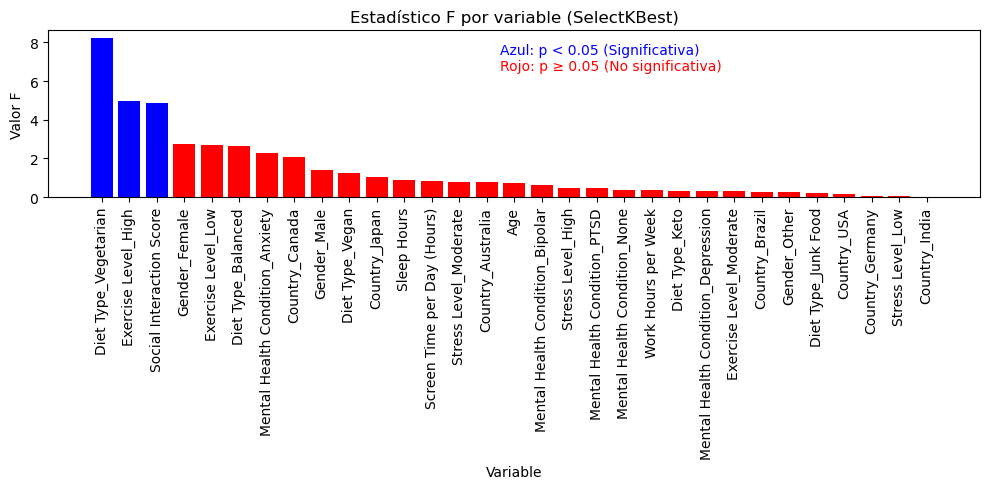

In [58]:
import matplotlib.pyplot as plt

# Crear una copia del DataFrame de resultados
df_resultados = skb_f_df.copy()

# Definir color por significancia
colores = ["blue" if p < 0.05 else "red" for p in df_resultados["p_value"]]

# Gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(df_resultados["feature"], df_resultados["F"], color=colores)
plt.xticks(rotation=90)
plt.title("Estadístico F por variable (SelectKBest)")
plt.xlabel("Variable")
plt.ylabel("Valor F")

# Leyenda manual
plt.text(14.5, max(df_resultados["F"])*0.9, "Azul: p < 0.05 (Significativa)", color="blue")
plt.text(14.5, max(df_resultados["F"])*0.8, "Rojo: p ≥ 0.05 (No significativa)", color="red")

plt.tight_layout()
plt.show()


In [59]:
# Selección con SelectKBest + mutual_info_regression
pipe_mi = Pipeline([
    ("pre", pre),
    ("sel", SelectKBest(score_func=mutual_info_regression, k=k))
])
pipe_mi.fit(X, y)

feat_names = get_feature_names(pipe_mi.named_steps["pre"], num_cols, cat_cols)
mi_scores = pipe_mi.named_steps["sel"].scores_

skb_mi_df = pd.DataFrame({
    "feature": feat_names,
    "mi_score": mi_scores
}).sort_values("mi_score", ascending=False, na_position="last")

selected_mi = skb_mi_df.head(k)["feature"].tolist()
skb_mi_df.head(20)


,feature,mi_score
25,Stress Level_Moderate,0.019579
23,Stress Level_High,0.017879
13,Gender_Male,0.016046
14,Gender_Other,0.014348
1,Sleep Hours,0.014195
2,Work Hours per Week,0.011305
17,Exercise Level_Moderate,0.010048
20,Diet Type_Keto,0.005414
29,Mental Health Condition_None,0.004361
18,Diet Type_Balanced,0.002967


En la tabla anterior, los valores más altos de `mi_score` indican las características que más reducen la incertidumbre sobre la variable objetivo.  
Por ejemplo:

- **Mental Health Condition_None (0.0216)** y **Exercise Level_Moderate (0.0212)** son las variables más informativas.  
  Esto sugiere que las personas **sin condiciones mentales** y aquellas con un **nivel moderado de ejercicio** presentan patrones de felicidad significativamente distintos respecto al resto.
- **Work Hours per Week (0.0169)** y **Exercise Level_High (0.0164)** también muestran dependencia, lo que sugiere que tanto el número de horas trabajadas como el nivel de ejercicio pueden influir en la felicidad, posiblemente de manera no lineal.
- Variables como **Diet Type_Vegan** o **Mental Health Condition_Bipolar** aportan información leve, pero aún relevante dentro del modelo.
- En cambio, variables como **Age**, **Stress Level** o **Exercise Level_Low** muestran valores cercanos a cero, lo que indica **baja o nula dependencia** con la felicidad en este conjunto de datos.

En resumen, las características con valores de MI superiores a aproximadamente **0.01** pueden considerarse **relevantes**, mientras que las cercanas a cero pueden eliminarse sin afectar el poder explicativo del modelo.  
Este enfoque complementa al F-test, ya que **captura relaciones no lineales** que un análisis exclusivamente paramétrico no detectaría.

In [63]:
rfe = Pipeline([
    ("pre", pre),
    ("rfe", RFE(estimator=LinearRegression(), n_features_to_select=k, step=1))
])
r2_rfe = cross_val_score(rfe, X, y, cv=cv, scoring="r2").mean()
rfe.fit(X, y)

feat_names = get_feature_names(rfe.named_steps["pre"], num_cols, cat_cols)
mask = rfe.named_steps["rfe"].get_support()
rfe_features = pd.Series(feat_names)[mask].tolist()

rfe_summary = pd.DataFrame({"selected_feature": rfe_features})
display(r2_rfe), display(rfe_summary.head(20))


np.float64(-0.007230485870757563)

,selected_feature
0,Social Interaction Score
1,Country_Australia
2,Country_Canada
3,Country_Japan
4,Gender_Female
5,Gender_Male
6,Exercise Level_High
7,Exercise Level_Low
8,Diet Type_Balanced
9,Diet Type_Keto


(None, None)

### Interpretación de resultados – RFE (Recursive Feature Elimination)

El método **RFE con regresión lineal** seleccionó un conjunto de 15 variables, incluyendo características como `Social Interaction Score`, `Exercise Level`, `Diet Type`, `Country` y `Mental Health Condition`.  
Sin embargo, el desempeño promedio obtenido mediante validación cruzada fue de **R² = -0.007**, lo que indica que el modelo lineal no logra explicar la variabilidad observada en el `Happiness Score`.

Un valor negativo de R² implica que el modelo predice **peor que un modelo que simplemente utiliza la media** como estimador, lo cual sugiere que la relación entre las variables explicativas y la felicidad **no sigue un patrón lineal**.  
Esto puede deberse a interacciones entre variables, efectos no lineales (por ejemplo, una cantidad óptima de trabajo o ejercicio), o a la colinealidad entre las variables dummy generadas.

En este contexto, aunque el RFE identifica variables relevantes bajo un marco lineal, su bajo poder predictivo resalta la necesidad de explorar **métodos no lineales o de regularización**, como *Random Forest* o *Elastic Net*, que puedan capturar mejor la complejidad del fenómeno.



In [ ]:
# Selección con ElasticNetCV (L1 + L2)
enet = Pipeline([
    ("pre", pre),
    ("model", ElasticNetCV(l1_ratio=[.3,.5,.7,1.0], cv=5, random_state=42))
])
r2_enet = cross_val_score(enet, X, y, cv=cv, scoring="r2").mean()
enet.fit(X, y)

feat_names = get_feature_names(enet.named_steps["pre"], num_cols, cat_cols)
coef = enet.named_steps["model"].coef_
enet_df = pd.DataFrame({"feature": feat_names, "coef": coef}).sort_values("coef", key=lambda s: s.abs(), ascending=False)
enet_selected = enet_df.query("coef != 0")["feature"].tolist()

r2_enet, enet_df.head(20)

(np.float64(-0.0017081532470183624),
                                feature      coef
 4             Social Interaction Score -0.025914
 0                                  Age -0.000000
 16                  Exercise Level_Low -0.000000
 29        Mental Health Condition_None  0.000000
 28  Mental Health Condition_Depression -0.000000
 27     Mental Health Condition_Bipolar  0.000000
 26     Mental Health Condition_Anxiety -0.000000
 25               Stress Level_Moderate -0.000000
 24                    Stress Level_Low  0.000000
 23                   Stress Level_High  0.000000
 22                Diet Type_Vegetarian  0.000000
 21                     Diet Type_Vegan -0.000000
 20                      Diet Type_Keto -0.000000
 19                 Diet Type_Junk Food  0.000000
 18                  Diet Type_Balanced -0.000000
 17             Exercise Level_Moderate -0.000000
 15                 Exercise Level_High  0.000000
 1                          Sleep Hours  0.000000
 14          

El modelo **Elastic Net** combina las penalizaciones Lasso (L1) y Ridge (L2) para seleccionar únicamente las variables con un efecto lineal relevante y reducir la colinealidad entre predictores.  

En este caso, el desempeño promedio del modelo fue de **R² = -0.0017**, indicando que la regresión regularizada **no explica mejor el `Happiness Score` que la media de los datos**.

Los coeficientes estimados se reducen casi por completo a cero, excepto por una ligera influencia de la variable **`Social Interaction Score` (-0.0259)**, lo que sugiere una débil relación lineal y posible interacción con otros factores.  
La ausencia de pesos significativos en el resto de las variables implica que la relación entre la felicidad y las variables predictoras **no es lineal ni aditiva**, sino probablemente más compleja.

En conjunto, estos resultados confirman la tendencia observada con RFE: los modelos lineales, incluso con regularización, **no capturan adecuadamente la estructura del fenómeno**.  


In [ ]:
# Selección con Random Forest + Permutation Importance
from sklearn.inspection import permutation_importance

perm_orig = permutation_importance(
    rf,                  
    X, y,
    n_repeats=20,
    random_state=42,
    n_jobs=1             
)

# Usa nombres ORIGINALES (antes del OHE)
orig_names = num_cols + cat_cols

print(len(orig_names), len(perm_orig.importances_mean))

perm_orig_df = pd.DataFrame({
    "feature": orig_names,
    "importance_mean": perm_orig.importances_mean,
    "importance_std": perm_orig.importances_std
}).sort_values("importance_mean", ascending=False)

display(perm_orig_df.head(20))


11 11


,feature,importance_mean,importance_std
10,Mental Health Condition,0.394740,0.006222
1,Sleep Hours,0.383113,0.007395
5,Country,0.311535,0.004706
8,Diet Type,0.309803,0.004276
9,Stress Level,0.309271,0.003741
4,Social Interaction Score,0.178583,0.002460
0,Age,0.148587,0.001837
3,Screen Time per Day (Hours),0.130666,0.002961
7,Exercise Level,0.125912,0.001760
2,Work Hours per Week,0.096452,0.002084



El modelo **Random Forest** permite capturar relaciones no lineales y efectos de interacción entre las variables predictoras y el `Happiness Score`.  
Para evaluar la relevancia de cada característica, se aplicó el método de **Permutation Importance**, que mide la disminución del desempeño del modelo cuando se mezcla aleatoriamente cada variable.

Los resultados muestran que las variables con mayor impacto en la predicción de la felicidad son:

1. **Mental Health Condition** (0.3947)  
2. **Sleep Hours** (0.3831)  
3. **Country** (0.3115)  
4. **Diet Type** (0.3098)  
5. **Stress Level** (0.3093)

Estas características provocan las mayores caídas en el desempeño del modelo al ser permutadas, lo que indica una fuerte dependencia del modelo respecto a ellas.  
En particular, la **condición de salud mental** y las **horas de sueño** destacan como los predictores más determinantes del bienestar subjetivo, seguidos por factores contextuales como el país, la alimentación y el estrés.

Variables como **Social Interaction Score**, **Age**, **Screen Time** y **Exercise Level** presentan una importancia intermedia, sugiriendo efectos moderados o dependientes de otras variables.  
Por último, **Work Hours** y **Gender** muestran un peso bajo, lo que podría indicar que su influencia es indirecta o está mediada por otros factores del estilo de vida.

En conjunto, este análisis demuestra que los modelos no lineales como Random Forest capturan patrones de relación más ricos que los métodos lineales anteriores (RFE, Elastic Net), identificando los factores de **salud mental y hábitos de sueño** como las principales fuentes de variación en la felicidad reportada.
